In [1]:
from TicTacToeEnv import TicTacToeAdvanced
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import random

In [2]:
class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 128)
        self.linear_2 = nn.Linear(128, 256)
        self.linear_3 = nn.Linear(256, 256)
        self.linear_4 = nn.Linear(256, 128)
        self.linear_5 = nn.Linear(128, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        hidden = self.linear_3(hidden)
        hidden = self.activation(hidden)
        hidden = self.linear_4(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_5(hidden)
        return actions


class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.95, lr=1e-3, batch_size=128, epsilon_decrease=1/10000, epsilon_min=0.2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data*0)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 25*20000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau, do_learn = True):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.1):]
            print('mem',len(self.memory))
        if(not do_learn):
            return
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [3]:
env = TicTacToeAdvanced()

In [4]:
%%time

state_dim = env.observation_space[0]**2
action_dim = env.action_space['n']
print(action_dim)


agents= [SDQN(state_dim, action_dim),SDQN(state_dim, action_dim)]

total_rewards = [[],[]]

5
CPU times: total: 0 ns
Wall time: 12.2 ms


In [5]:
%%time

episode_n = 100000
step = 5000

for episode in range(episode_n):    
    total_reward = [0,0]
    states = []
    rewards = []
    actions = []
    dones = []
    state = env.reset()
    state = state.reshape(-1)
    for t in range(30):
        #not multiplied last 4 states
        states.append(state)
        player_index = env.player_index
        
        
        state = state*((-1)**(env.player_index+1))
        action = agents[player_index].get_action([state])
        next_state, reward, done, correct = env.step(action[0])
        next_state = next_state.reshape(-1)
        actions.append(action[0])
        dones.append(done)
        rewards.append(reward)
        if len(states) > 1:
            
            total_reward[env.player_index] = -rewards[-1] if (dones[-1] and not dones[-2]) else rewards[-2]
            agents[env.player_index].fit(
                states[-2]*((-1)**(env.player_index+1)),
                actions[-2].astype(np.longlong),
                # if done now (done[-1]) we learn prev net that last move was bad
                # but if prev was done we lern prev net that it was great or normal
                -rewards[-1] if (dones[-1] and not dones[-2]) else rewards[-2],
                np.array((dones[-2] or dones[-1]),dtype = np.longlong),
                next_state*((-1)**(env.player_index+1)),
                0.05,
                ((((episode/step)%2>=1) - 0) == env.player_index)
            )
            if False:
                print(episode,'\n',(states[-2]*((-1)**(env.player_index+1))).reshape((5,5)),'\n',
                    actions[-2],
                    # if done now (done[-1]) we learn prev net that last move was bad
                    # but if prev was done we lern prev net that it was great or normal
                    -rewards[-1] if (dones[-1] and not dones[-2]) else rewards[-2],'\n',
                    np.array((dones[-2] or dones[-1]),dtype = np.longlong),'\n',
                    (next_state*((-1)**(env.player_index+1))).reshape((5,5)),
                    0.05,
                    ((((episode/step)%2>=1) - 0) == env.player_index))
        state = next_state
        states = states[-4:]
        rewards = rewards[-4:]
        actions = actions[-4:]
        dones = dones[-4:]
        if len(dones)>2 and dones[-2]:
            break
            
    total_rewards[0].append(total_reward[0])
    total_rewards[1].append(total_reward[1])
    if episode%100==0:
        print(episode,total_reward,agents[0].epsilon,agents[1].epsilon)

plt.plot(total_rewards[0])
plt.plot(total_rewards[1])


C:\Users\boh-b\AppData\Local\Temp\ipykernel_24684\4102158483.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  q_values = self.q_function(torch.FloatTensor(state))


0 [0, 100] 1 1
100 [0, 100] 0.9199000000000088 1
200 [0, 100] 0.827400000000019 1
300 [0, 100] 0.7413000000000285 1
400 [0, 100] 0.6521000000000383 1
500 [100, 0] 0.5680000000000476 1
600 [0, 100] 0.48840000000005634 1
700 [100, 0] 0.40920000000006507 1
800 [0, 100] 0.33320000000007344 1
900 [0, 100] 0.2609000000000814 1
1000 [0, 100] 0.19990000000008812 1
1100 [0, 100] 0.19990000000008812 1
1200 [100, 0] 0.19990000000008812 1
1300 [0, 100] 0.19990000000008812 1
1400 [0, 100] 0.19990000000008812 1
1500 [100, 0] 0.19990000000008812 1
1600 [100, 0] 0.19990000000008812 1
1700 [100, 0] 0.19990000000008812 1
1800 [0, 100] 0.19990000000008812 1
1900 [100, 0] 0.19990000000008812 1
2000 [100, 0] 0.19990000000008812 1
2100 [0, 0] 0.19990000000008812 1
2200 [0, 100] 0.19990000000008812 1
2300 [0, 100] 0.19990000000008812 1
2400 [0, 100] 0.19990000000008812 1
2500 [0, 0] 0.19990000000008812 1
2600 [100, 0] 0.19990000000008812 1
2700 [0, 100] 0.19990000000008812 1
2800 [0, 100] 0.19990000000008812

16900 [100, 0] 0.19990000000008812 0.19990000000008812
17000 [100, 0] 0.19990000000008812 0.19990000000008812
17100 [0, 0] 0.19990000000008812 0.19990000000008812
17200 [100, 0] 0.19990000000008812 0.19990000000008812
17300 [0, 100] 0.19990000000008812 0.19990000000008812
17400 [100, 0] 0.19990000000008812 0.19990000000008812
17500 [100, 0] 0.19990000000008812 0.19990000000008812
17600 [0, 0] 0.19990000000008812 0.19990000000008812
17700 [0, 0] 0.19990000000008812 0.19990000000008812
17800 [100, 0] 0.19990000000008812 0.19990000000008812
17900 [100, 0] 0.19990000000008812 0.19990000000008812
18000 [0, 0] 0.19990000000008812 0.19990000000008812
18100 [100, 0] 0.19990000000008812 0.19990000000008812
18200 [100, 0] 0.19990000000008812 0.19990000000008812
18300 [100, 0] 0.19990000000008812 0.19990000000008812
18400 [100, 0] 0.19990000000008812 0.19990000000008812
18500 [100, 0] 0.19990000000008812 0.19990000000008812
18600 [100, 0] 0.19990000000008812 0.19990000000008812
18700 [0, 100] 0.1

31900 [0, 0] 0.19990000000008812 0.19990000000008812
32000 [100, 0] 0.19990000000008812 0.19990000000008812
32100 [100, 0] 0.19990000000008812 0.19990000000008812
32200 [100, 0] 0.19990000000008812 0.19990000000008812
32300 [100, 0] 0.19990000000008812 0.19990000000008812
32400 [100, 0] 0.19990000000008812 0.19990000000008812
32500 [100, 0] 0.19990000000008812 0.19990000000008812
32600 [0, 100] 0.19990000000008812 0.19990000000008812
32700 [100, 0] 0.19990000000008812 0.19990000000008812
32800 [100, 0] 0.19990000000008812 0.19990000000008812
32900 [100, 0] 0.19990000000008812 0.19990000000008812
33000 [100, 0] 0.19990000000008812 0.19990000000008812
33100 [100, 0] 0.19990000000008812 0.19990000000008812
33200 [0, 100] 0.19990000000008812 0.19990000000008812
33300 [100, 0] 0.19990000000008812 0.19990000000008812
33400 [100, 0] 0.19990000000008812 0.19990000000008812
33500 [100, 0] 0.19990000000008812 0.19990000000008812
33600 [100, 0] 0.19990000000008812 0.19990000000008812
33700 [0, 0]

46900 [100, 0] 0.19990000000008812 0.19990000000008812
47000 [100, 0] 0.19990000000008812 0.19990000000008812
47100 [100, 0] 0.19990000000008812 0.19990000000008812
47200 [0, 0] 0.19990000000008812 0.19990000000008812
47300 [100, 0] 0.19990000000008812 0.19990000000008812
47400 [0, 100] 0.19990000000008812 0.19990000000008812
47500 [100, 0] 0.19990000000008812 0.19990000000008812
47600 [0, 100] 0.19990000000008812 0.19990000000008812
47700 [0, 100] 0.19990000000008812 0.19990000000008812
47800 [100, 0] 0.19990000000008812 0.19990000000008812
47900 [100, 0] 0.19990000000008812 0.19990000000008812
48000 [100, 0] 0.19990000000008812 0.19990000000008812
48100 [0, 100] 0.19990000000008812 0.19990000000008812
48200 [100, 0] 0.19990000000008812 0.19990000000008812
48300 [100, 0] 0.19990000000008812 0.19990000000008812
48400 [100, 0] 0.19990000000008812 0.19990000000008812
48500 [100, 0] 0.19990000000008812 0.19990000000008812
48600 [100, 0] 0.19990000000008812 0.19990000000008812
48700 [100, 

61900 [100, 0] 0.19990000000008812 0.19990000000008812
62000 [100, 0] 0.19990000000008812 0.19990000000008812
62100 [100, 0] 0.19990000000008812 0.19990000000008812
62200 [100, 0] 0.19990000000008812 0.19990000000008812
62300 [0, 100] 0.19990000000008812 0.19990000000008812
62400 [0, 100] 0.19990000000008812 0.19990000000008812
62500 [100, 0] 0.19990000000008812 0.19990000000008812
62600 [0, 100] 0.19990000000008812 0.19990000000008812
62700 [100, 0] 0.19990000000008812 0.19990000000008812
62800 [0, 100] 0.19990000000008812 0.19990000000008812
62900 [100, 0] 0.19990000000008812 0.19990000000008812
63000 [100, 0] 0.19990000000008812 0.19990000000008812
63100 [100, 0] 0.19990000000008812 0.19990000000008812
63200 [0, 100] 0.19990000000008812 0.19990000000008812
63300 [100, 0] 0.19990000000008812 0.19990000000008812
63400 [0, 100] 0.19990000000008812 0.19990000000008812
63500 [100, 0] 0.19990000000008812 0.19990000000008812
63600 [0, 100] 0.19990000000008812 0.19990000000008812
63700 [100

76800 [100, 0] 0.19990000000008812 0.19990000000008812
76900 [100, 0] 0.19990000000008812 0.19990000000008812
77000 [100, 0] 0.19990000000008812 0.19990000000008812
77100 [0, 100] 0.19990000000008812 0.19990000000008812
77200 [100, 0] 0.19990000000008812 0.19990000000008812
77300 [0, 100] 0.19990000000008812 0.19990000000008812
77400 [100, 0] 0.19990000000008812 0.19990000000008812
77500 [0, 100] 0.19990000000008812 0.19990000000008812


KeyboardInterrupt: 

In [47]:
for mem in agents[0].memory[5000:5090]:
    print(mem[0].reshape((5,5)),'\n action =',mem[1],'\n reward =',mem[2],'done =',mem[3],'\n',mem[4].reshape((5,5)))

[[-1. -0.  1. -0. -0.]
 [ 1. -0. -1. -0. -0.]
 [-1. -1.  1.  1. -0.]
 [ 1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.]] 
 action = 3 
 reward = 100 done = 1 
 [[-1. -0.  1. -1. -0.]
 [ 1. -0. -1.  1. -0.]
 [-1. -1.  1.  1. -0.]
 [ 1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1.]]
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]] 
 action = 2 
 reward = 0 done = 0 
 [[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0.]
 [-0. -0.  1. -0. -0.]]
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0.]
 [-0. -0.  1. -0. -0.]] 
 action = 0 
 reward = 0 done = 0 
 [[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-1. -0. -1. -0. -0.]
 [ 1. -0.  1. -0. -0.]]
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-1. -0. -1. -0. -0.]
 [ 1. -0.  1. -0. -0.]] 
 action = 4 
 reward = 0 done = 0 
 [[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -

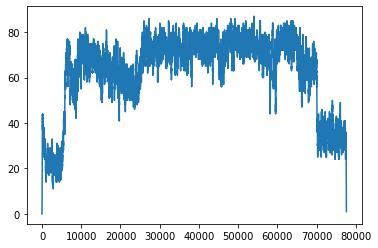

In [6]:
plt.plot(np.convolve(total_rewards[0],np.ones(100)/100))

In [8]:
done = False
state = env.reset()
env.render()
agent = 1
while not done:
    correct = False
    while not correct:
        if env.player_index:
            state = state.reshape(-1)
            state = state*((-1)**(agent+1))
            agents[agent].epsilon = 0.01
            action = agents[agent].get_action([state])[0]
        else:
            action = int(input(f'{env.player_index}-th player turn to act (enter number from 1 to {env.n})')) - 1
        state, reward, done, correct = env.step(action)
        print(reward)
        env.render()
        agents[agent].epsilon = 0.2
    

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
0-th player turn to act (enter number from 1 to 5)3
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]]
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.]]
0-th player turn to act (enter number from 1 to 5)3
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.]]
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.]]
0-th player turn to act (enter number from 1 to 5)2
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0. -1. -1.  0.  1.]]
0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.]]
0-th player turn to act (enter number from 1 

#### 

In [83]:
agents[1].q_function(torch.Tensor([np.array([0,0,0,0,0,
                               0,0,0,0,0,
                               0,0,0,0,0,
                               -1,0,0,0,0,
                               -1,0,1,0,1])]))

tensor([[12.3794, 14.0461, 15.5236, 14.7038, 14.6825]],
       grad_fn=<AddmmBackward0>)

In [46]:

        agents[agent].epsilon = 0.2

In [48]:
 agents[0].epsilon = 0.2